<a href="https://colab.research.google.com/github/Paulsob/TelecomLabs/blob/main/Lab4_telecom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

from thinkdsp import normalize, unbias, read_wave, PinkNoise, decorate, UncorrelatedGaussianNoise, Spectrum, Wave, Noise
import numpy as np

--2025-05-14 19:39:18--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py [following]
--2025-05-14 19:39:18--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48554 (47K) [text/plain]
Saving to: ‘thinkdsp.py’

thinkdsp.py         100%[===================>]  47.42K  --.-KB/s    in 0.01s   

2025-05-14 19:39:18 (3.43 MB/s) - ‘thinkdsp.py’ saved [48554/48554]



In [2]:
wave1 = read_wave(filename='storm.wav').segment(start=0, duration=3)
wave2 = read_wave(filename='birds.wav').segment(start=0)

Шум моря

In [3]:
wave1.make_audio()

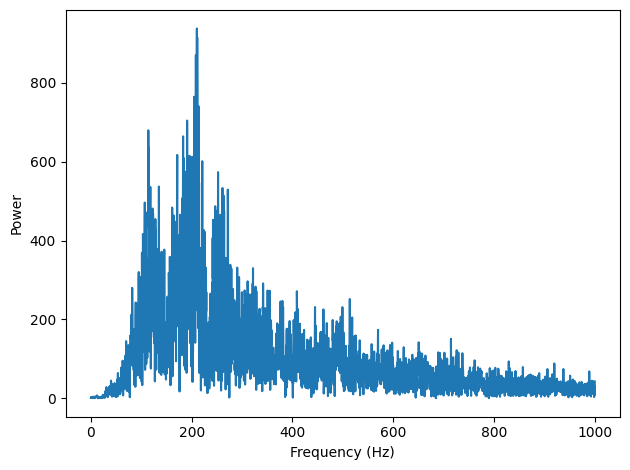

In [4]:
wave1.make_spectrum().plot(high=1000)
decorate(xlabel='Frequency (Hz)', ylabel='Power')

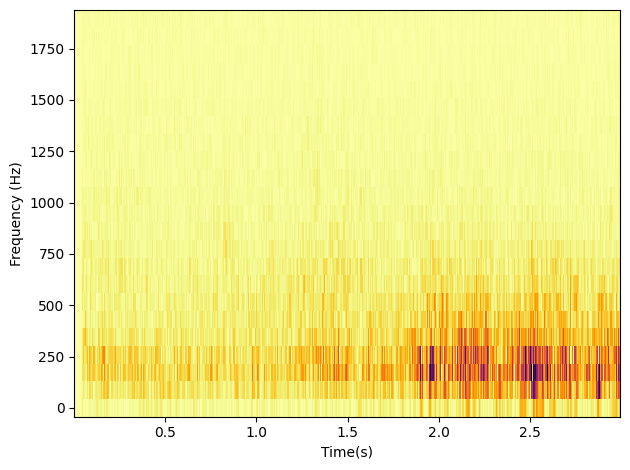

In [5]:
wave1.make_spectrogram(512).plot(high=2000)
decorate(xlabel='Time(s)', ylabel='Frequency (Hz)')

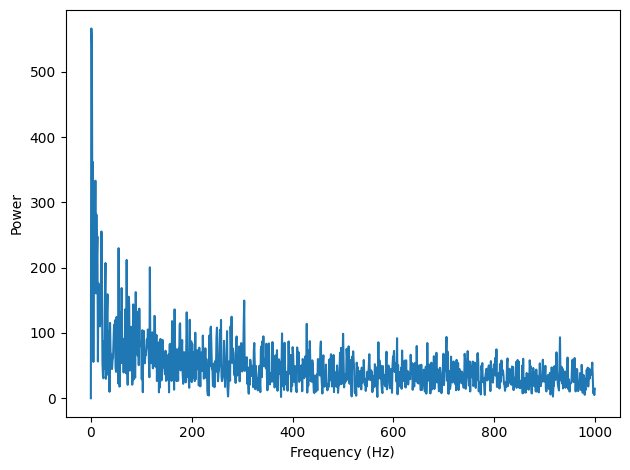

In [6]:
pink = PinkNoise(amp=1.0, beta=0.8).make_wave(duration=1)
pink.make_spectrum().plot(high=1000)
decorate(xlabel='Frequency (Hz)', ylabel='Power')

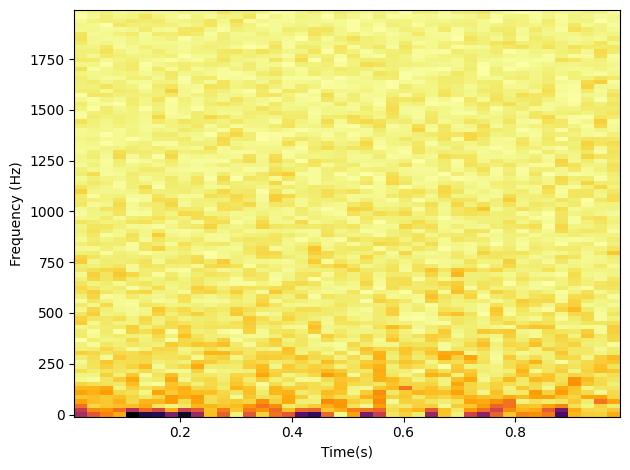

In [7]:
pink.make_spectrogram(512).plot(high=2000)
decorate(xlabel='Time(s)', ylabel='Frequency (Hz)')

Шум птиц

In [8]:
wave2.make_audio()

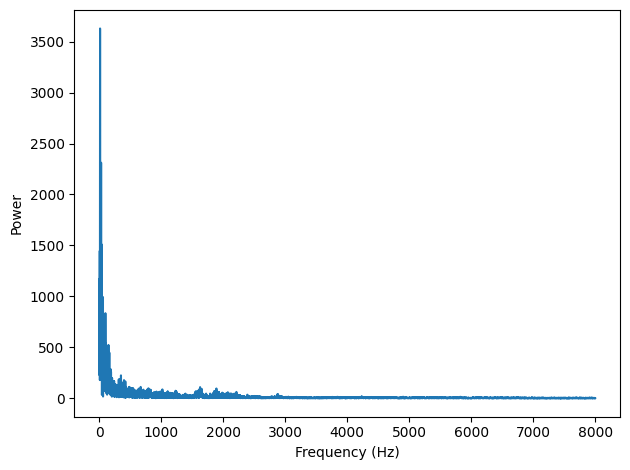

In [9]:
wave2.make_spectrum().plot(high=8000)
decorate(xlabel='Frequency (Hz)', ylabel='Power')

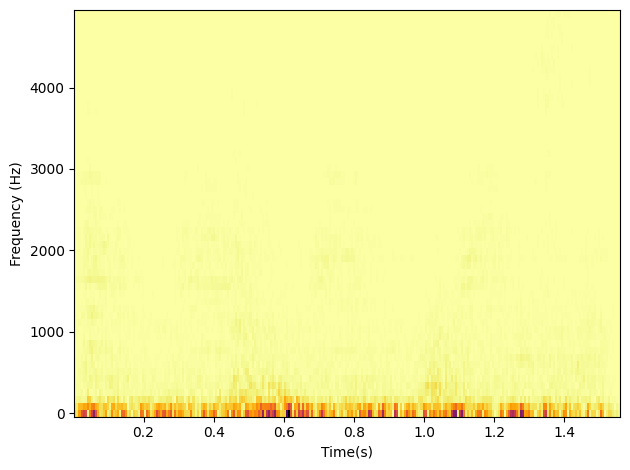

In [10]:
wave2.make_spectrogram(512).plot(high=5000)
decorate(xlabel='Time(s)', ylabel='Frequency (Hz)')

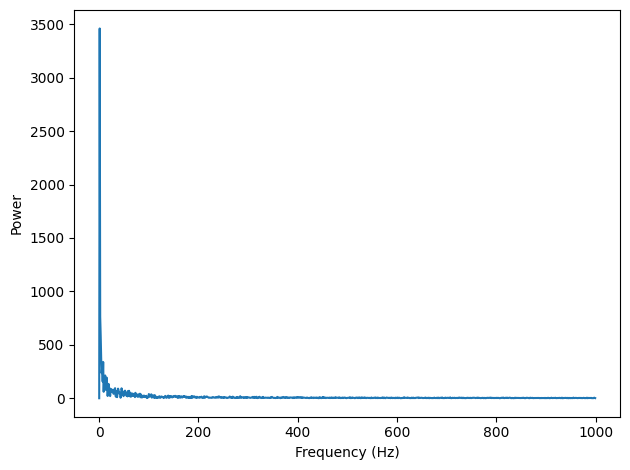

In [11]:
ug = PinkNoise(amp=1.0, beta=2).make_wave(duration=1)
ug.make_spectrum().plot(high=1000)
decorate(xlabel='Frequency (Hz)', ylabel='Power')

Пункт 2

In [12]:
def bartlett(wave, seg_length=512, win_flag=True):
    spectrogram = wave.make_spectrogram(seg_length, win_flag)
    spectrums = spectrogram.spec_map.values()
    psds = [spectrum.power for spectrum in spectrums]
    hs = np.sqrt(sum(psds) / len(psds))
    fs = next(iter(spectrums)).fs
    return Spectrum(hs, fs, wave.framerate)

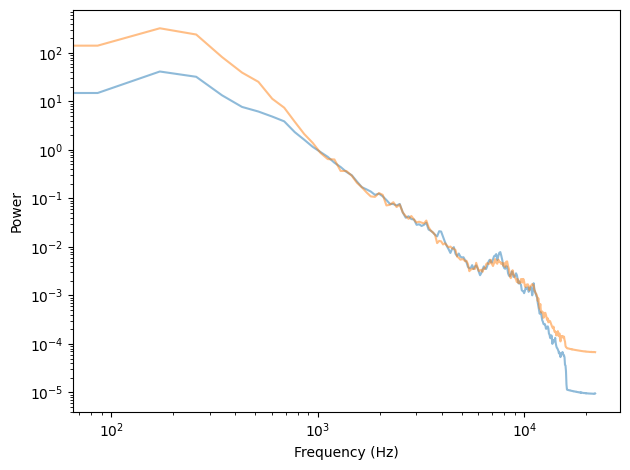

In [13]:
bartlett(wave1.segment(start=0, duration=1.9)).plot_power(alpha=0.5)
bartlett(wave1.segment(start=2, duration=1.9)).plot_power(alpha=0.5)
decorate(xlabel='Frequency (Hz)', ylabel='Power', xscale='log', yscale='log')

Пункт 3

In [14]:
import pandas as pd

df = pd.read_csv('Bitcoin-price-USD.csv')
df

,Date,Price
0,2010-07-18,0.090000
1,2010-07-19,0.080000
2,2010-07-20,0.070000
3,2010-07-21,0.080000
4,2010-07-22,0.050000
...,...,...
5134,2024-08-07,55027.460938
5135,2024-08-08,61710.136719
5136,2024-08-09,60880.113281
5137,2024-08-10,60945.812500


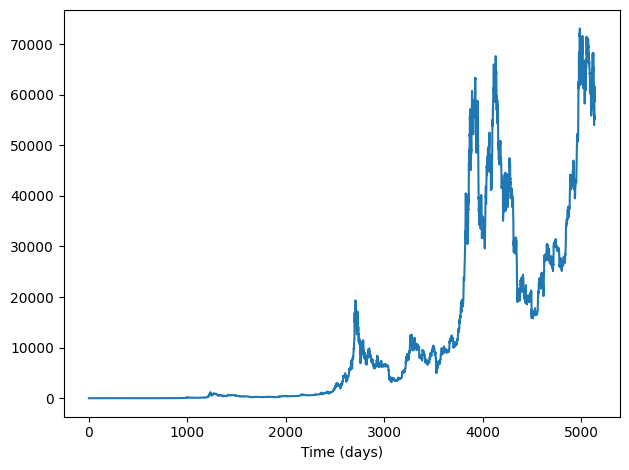

In [15]:
btc = Wave(
    ys=df['Price'],
    ts=df.index,
    framerate=1,
)
btc.plot()
decorate(xlabel='Time (days)')

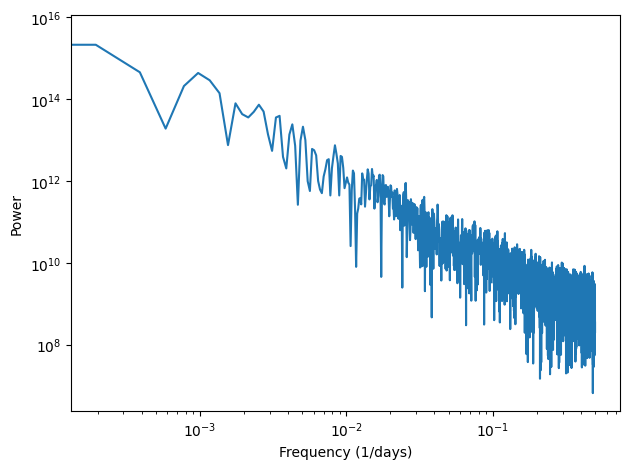

In [16]:
btc_spectrum = btc.make_spectrum()
btc_spectrum.plot_power()
decorate(xlabel='Frequency (1/days)', ylabel='Power', xscale='log', yscale='log')

In [17]:
btc_spectrum.estimate_slope()[0]

np.float64(-1.8141987193262041)

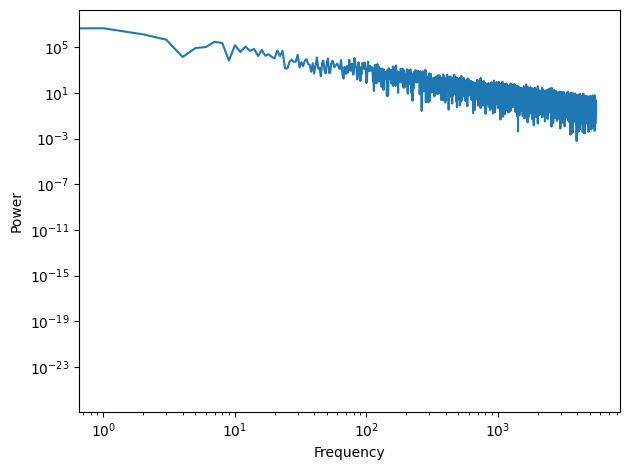

In [18]:
PinkNoise(beta=1.814).make_wave().make_spectrum().plot_power()
decorate(xlabel='Frequency', ylabel='Power', xscale='log', yscale='log')

Пункт 4

In [19]:
class UncorrelatedPoissonNoise(Noise):
    def evaluate(self, ts):
        ys = np.random.poisson(self.amp, len(ts))
        return ys

In [20]:
fish1 = UncorrelatedPoissonNoise(amp=0.001).make_wave(duration=2, framerate=10000)
fish1.make_audio()

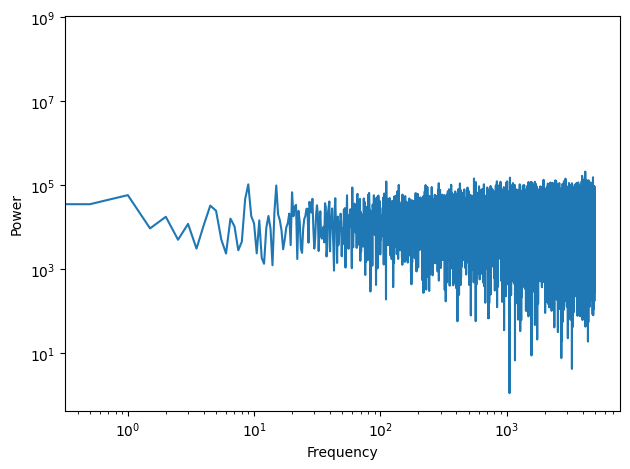

In [21]:
fish2 = UncorrelatedPoissonNoise(amp=1).make_wave(duration=2, framerate=10000)
fish2.make_spectrum().plot_power()
decorate(xlabel='Frequency', ylabel='Power', xscale='log', yscale='log')
fish2.make_audio()

Пункт 5

In [22]:
def voss(nrows, ncols=16):
    matrix = np.empty((nrows, ncols))
    matrix.fill(np.nan)
    matrix[0, :] = np.random.random(ncols)
    matrix[:, 0] = np.random.random(nrows)

    # the total number of changes is nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    matrix[rows, cols] = np.random.random(n)

    df = pd.DataFrame(matrix)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)

    return total.values

In [23]:
ys = voss(10000)
wave = Wave(ys=ys, framerate=10000)
wave.unbias()
wave.normalize()

wave.make_audio()

<ipython-input-22-6374c997f303>:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', axis=0, inplace=True)


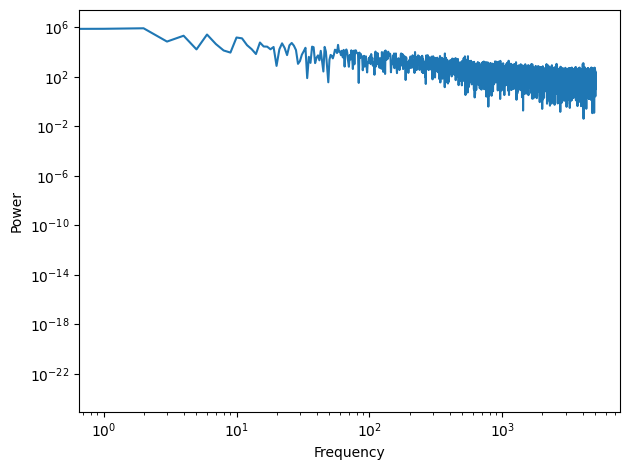

In [24]:
spectrum = wave.make_spectrum()
spectrum.plot_power()
decorate(xlabel='Frequency', ylabel='Power', xscale='log', yscale='log')

In [25]:
spectrum.estimate_slope().slope

np.float64(-0.998045812455224)